In [2]:
# Importación de librerías
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# Leer los archivos LOG y almacenarlos en dataframes independientes
df_agustinas = pd.read_csv("Log_Agustinas.txt", sep=" ", header=None, usecols=[0,1,2,3,4])
df_morande = pd.read_csv("Log_Morande.txt", sep=" ", header=None, usecols=[0,1,2,3,4])
# Insertar headers de las columnas 
df_agustinas.columns = ["frame", "sem_fase", "veh_agus", "ped_agus", "wait_agus"]
df_morande.columns = ["frame", "sem_fase", "veh_mor", "ped_mor", "wait_mor"]
# Realizar merge del tensor de datos
merged_df = pd.merge(df_agustinas, df_morande, on="frame") 

In [22]:
!pip install openpyxl

     -------------------------------------- 250.0/250.0 kB 1.2 MB/s eta 0:00:00


In [23]:
merged_df.to_excel("merged.xlsx", index=False)

In [63]:
merged_df

,frame,sem_fase_x,veh_agus,ped_agus,wait_agus,sem_fase_y,veh_mor,ped_mor,wait_mor
0,1,1,0,0,0,1,0,0,0
1,2,1,0,0,0,1,0,0,0
2,3,1,4,0,0,1,3,0,0
3,4,1,4,0,0,1,3,0,1
4,5,1,4,0,4,1,3,0,4
...,...,...,...,...,...,...,...,...,...
6808,6809,2,8,0,517,2,6,0,1643
6809,6810,2,9,0,522,2,6,0,1649
6810,6811,2,9,0,528,2,6,0,1655
6811,6812,2,9,0,534,2,6,0,1662


In [4]:
merged_df = merged_df.rename(columns={'sem_fase_x': 'sem_fase'})
merged_df = merged_df.drop('sem_fase_y', axis=1)

In [80]:
merged_df

,frame,sem_fase,veh_agus,ped_agus,wait_agus,veh_mor,ped_mor,wait_mor,Y
0,1,1,0,0,0,0,0,0,0
1,2,1,0,0,0,0,0,0,0
2,3,1,4,0,0,3,0,0,0
3,4,1,4,0,0,3,0,1,0
4,5,1,4,0,4,3,0,4,0
...,...,...,...,...,...,...,...,...,...
6808,6809,2,8,0,517,6,0,1643,0
6809,6810,2,9,0,522,6,0,1649,0
6810,6811,2,9,0,528,6,0,1655,0
6811,6812,2,9,0,534,6,0,1662,0


<AxesSubplot:xlabel='frame'>

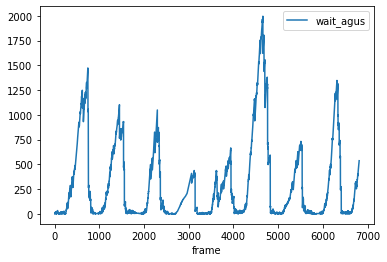

In [5]:
# Graficar los datos.
merged_df.plot(x="frame", y="wait_agus")

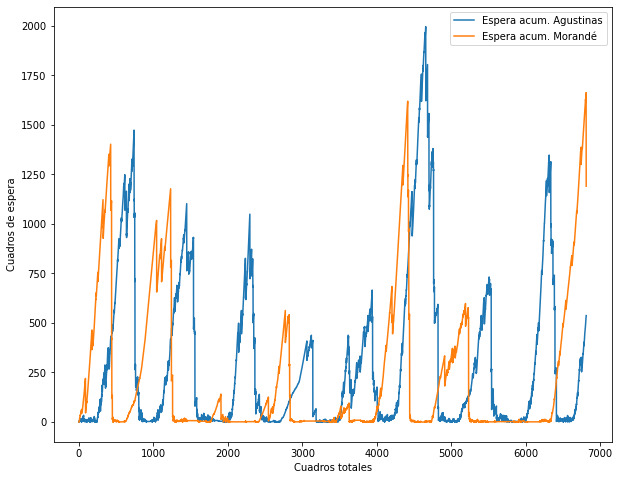

In [6]:
fig, axes = plt.subplots(figsize=(10,8))
axes.plot(merged_df['frame'], merged_df['wait_agus'], label="Espera acum. Agustinas")
axes.plot(merged_df['frame'], merged_df['wait_mor'],  label="Espera acum. Morandé")
axes.set_xlabel('Cuadros totales')
axes.set_ylabel('Cuadros de espera')
axes.legend()

plt.show()

In [7]:
import plotly.express as px
import plotly.graph_objects as go

fig1 = px.area(merged_df, x="frame", y="wait_agus", color="sem_fase")
fig2 = px.area(merged_df, x="frame", y="wait_mor", color="sem_fase")

fig1.show()
fig2.show()

fig = go.Figure(data = fig1.data + fig2.data)
fig.show()

In [10]:
df = merged_df

# Cleaning the data

# Vamos a hacer drop de las columnas que indican la cantidad de peatones. 

df = df.drop('frame', axis=1)
df = df.drop('ped_agus', axis=1)
df = df.drop('ped_mor', axis=1)

# Función que permite categorizar una nueva columna y establecer
# las reglas para para el modelo de descición

# Nota: 
# Fase 1 - fase Agustinas
# Fase 2 - fase peatonal
# Fase 0 - fase Morandé 

def categorize(row):
    wait_threshold = 500
    max_veh_threshold = 2
    if row['sem_fase'] == 1 and row['veh_agus'] < 2 and row['wait_mor'] > wait_threshold:
        return 1
    elif row['sem_fase'] == 0 and row['veh_mor'] < 2 and row['wait_agus'] > wait_threshold:
        return 1
    else:
        return 0

df['Y'] = df.apply(categorize, axis=1)

# Se exporta el dataframe a un excel para observarlo de mejor forma.
df.to_excel("df.xlsx", index=False)

In [97]:
# Escalado de columnas
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

df[['sem_fase',	'veh_agus',	'wait_agus', 'veh_mor',	'wait_mor']] = sc.fit_transform(df[['sem_fase', 'veh_agus',	'wait_agus', 'veh_mor',	'wait_mor']])

df.to_excel("df_scaled.xlsx", index=False)

In [11]:
# Creating training and validation sets

#Splitting the dataset into  training and validation sets
from sklearn.model_selection import train_test_split
training_set, validation_set = train_test_split(df, test_size = 0.15, random_state = 7)

#classifying the predictors and target variables as X and Y
X_train = training_set.iloc[:,0:-1].values
X_test = validation_set.iloc[:,0:-1].values
Y_train = training_set.iloc[:,-1].values
Y_test = validation_set.iloc[:,-1].values

In [12]:
len(X_train)

5791

In [ ]:
import numpy as np
np.set_printoptions(threshold=sys.maxsize)
print(Y_train)

In [122]:
def accuracy(confusion_matrix):
    diagonal_sum = confusion_matrix.trace()
    sum_of_all_elements = confusion_matrix.sum()
    return diagonal_sum / sum_of_all_elements

In [156]:
# Importing MLPClassifier
from sklearn.neural_network import MLPClassifier
# Initializing the MLPClassifier
classifier = MLPClassifier(hidden_layer_sizes=(150,100,50), max_iter=300, activation='relu', solver='adam', random_state=1)
# Fitting the training data to the network
classifier.fit(X_train, Y_train)

#Predicting y for X_val
y_pred = classifier.predict(X_test)

In [158]:
a = np.array([[0,10,800,1,0]])
#a.reshape(-1,1)
test_pred = classifier.predict(a)
test_pred

array([0], dtype=int64)

array([0], dtype=int64)

In [136]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('Exactitud:', accuracy_score(Y_test, y_pred))
print('Precisión:', precision_score(Y_test, y_pred, average='macro'))
print('Recall:', recall_score(Y_test, y_pred, average='macro'))
print('F1-score:', f1_score(Y_test, y_pred, average='macro'))

Exactitud: 0.9706457925636007
Precisión: 0.9850299401197604
Recall: 0.7
F1-score: 0.778115501519757


In [137]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(Y_test, y_pred)

print('Matriz de confusión:\n', cm)

Matriz de confusión:
 [[972   0]
 [ 30  20]]


In [151]:
# MLP Model

# Example training data
X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([0, 1, 1, 0])

# Create an MLPClassifier object
mlp = MLPClassifier(hidden_layer_sizes=(10,), max_iter=10000, random_state=0)

# Fit the model to the training data
mlp.fit(X, y)



In [159]:
# Predict the outcome for new data
X_new = np.array([[1, 1]])
prediction = mlp.predict(X_new)
prediction

array([0])

Nuevo enfoque...

El conjunto de datos de entrenamiento utilizado no tiene la capacidad de entrenar de forma correcta el modelo, ya que los datos no estan distribuídos de manera uniforme. Es por esto que se buscará generar un conjunto de datos de prueba artificial para entrenar el modelo. 

El conjunto de datos de entrenamiento artificial contará con la generación de: <br>
estados de fase (0,1,2) <br>
cantidad de vehículos en Agustinas (0-15)<br>
cantidad de vehículos en Morandé (0-15)<br>
cantidad de peatones en Agustinas (0-15)<br>
cantidad de peatones en Morandé (0-15)<br>
tiempo de espera acumulado en Agustinas (0-2000)<br>
tiempo de espera acumulado en Morandé (0-2000)

In [4]:
from itertools import product


In [5]:
fase = range(0, 3)
cantidades_10 = range(0, 11)
cantidades_16 = range(0, 17)
esperas_2000 = range(0,2006,5)
esperas_1700 = range(0,1706,5) 
combinaciones = list(product(fase, cantidades_16, esperas_2000, cantidades_10, esperas_1700))
df_generado = pd.DataFrame(combinaciones, columns=['sem_fase', 'veh_agus','wait_agus','veh_mor','wait_mor'])



In [1]:
print(df_generado)

NameError: name 'df_generado' is not defined

In [7]:
df_generado.mean()

sem_fase        1.0
veh_agus        8.0
wait_agus    1002.5
veh_mor         5.0
wait_mor      852.5
dtype: float64

In [8]:
df_sample = df_generado.sample(n=100000)

In [9]:
def categorize(row):
    wait_threshold = 500
    max_veh_threshold = 2
    if row['sem_fase'] == 1 and row['veh_agus'] <= max_veh_threshold and row['wait_mor'] > wait_threshold:
        return 1
    elif row['sem_fase'] == 0 and row['veh_mor'] <= max_veh_threshold and row['wait_agus'] > wait_threshold:
        return 1
    else:
        return 0

df_sample['Y'] = df_sample.apply(categorize, axis=1)

In [10]:
df_sample["Y"].mean()

0.10927

In [11]:
# Creating training and validation sets

#Splitting the dataset into  training and validation sets
from sklearn.model_selection import train_test_split
training_set, validation_set = train_test_split(df_sample, test_size = 0.25, random_state = 7)

#classifying the predictors and target variables as X and Y
X_train = training_set.iloc[:,0:-1].values
X_test = validation_set.iloc[:,0:-1].values
Y_train = training_set.iloc[:,-1].values
Y_test = validation_set.iloc[:,-1].values

In [12]:
# Importing MLPClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

# Initializing the MLPClassifier
model = MLPClassifier(hidden_layer_sizes=(32,), max_iter=1000, activation='relu', solver='adam', random_state=1)
# Fitting the training data to the network
model.fit(X_train, Y_train)

MLPClassifier(hidden_layer_sizes=(32,), max_iter=1000, random_state=1)

In [ ]:
train_sizes = np.linspace()

In [26]:
# Obtenemos los scores de entrenamiento y validación para cada tamaño de conjunto de entrenamiento
train_scores, valid_scores = learning_curve(model, X_train, Y_train)

c:\Users\javie\anaconda3\envs\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:699: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
c:\Users\javie\anaconda3\envs\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:699: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
c:\Users\javie\anaconda3\envs\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:699: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


In [56]:
import numpy as np
#Predicting y for X_val

a = np.array([[0,10,1800,1,0]])
test_pred = classifier.predict(a)
print(test_pred)

[1]


In [ ]:
# Definimos los tamaños de los conjuntos de entrenamiento y validación
# train_sizes = [1000000, 500000, 200000, 50000, 10000, 5000]

# Obtenemos los scores de entrenamiento y validación para cada tamaño de conjunto de entrenamiento
#train_scores, valid_scores = learning_curve(model, X, y, train_sizes=train_sizes)

# Calculamos las medias y desviaciones estándar de los scores de entrenamiento y validación
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
valid_mean = np.mean(valid_scores, axis=1)
valid_std = np.std(valid_scores, axis=1)

# Graficamos la curva de entrenamiento
plt.plot(train_sizes, train_mean, label='Training score')
plt.plot(train_sizes, valid_mean, label='Cross-validation score')

# Agregamos las bandas de incertidumbre
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.fill_between(train_sizes, valid_mean - valid_std, valid_mean + valid_std, alpha=0.1)

# Agregamos etiquetas y leyenda
plt.xlabel('Training Size')
plt.ylabel('Score')
plt.title('Learning Curve')
plt.legend(loc='best')

# Mostramos la gráfica
plt.show()